In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict



In [2]:
env = gym.make("Blackjack-v1", sab=True)


In [3]:
def fixed_policy(state):
    player_sum, dealer_card, usable_ace = state
    return 0 if player_sum >= 20 else 1
def generate_episode_prediction(env, policy):
    episode = []
    state, _ = env.reset()

    done = False
    while not done:
        action = policy(state)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, reward))
        state = next_state

    return episode
def mc_prediction(env, policy, num_episodes=10_000):
    returns = defaultdict(list)
    V = defaultdict(float)

    for _ in range(num_episodes):
        episode = generate_episode_prediction(env, policy)
        G = 0
        visited_states = set()

        for t in reversed(range(len(episode))):
            state, reward = episode[t]
            G += reward

            if state not in visited_states:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
                visited_states.add(state)

    return V
V = mc_prediction(env, fixed_policy)

# Compare values
state_21 = (21, 10, False)
state_5  = (5, 10, False)

print("V(PlayerSum=21):", V[state_21])
print("V(PlayerSum=5): ", V[state_5])


V(PlayerSum=21): 0.8680351906158358
V(PlayerSum=5):  -0.4594594594594595


In [4]:
Q = defaultdict(lambda: np.zeros(2))
returns_count = defaultdict(lambda: np.zeros(2))
def epsilon_greedy(Q, state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1])
    else:
        return np.argmax(Q[state])
def generate_episode_control(env, Q, epsilon):
    episode = []
    state, _ = env.reset()
    done = False

    while not done:
        action = epsilon_greedy(Q, state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

    return episode
def mc_control(env, num_episodes=500_000, alpha=0.01, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(2))
    rewards = []

    for episode_num in range(num_episodes):
        episode = generate_episode_control(env, Q, epsilon)
        G = 0

        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G += reward

            Q[state][action] += alpha * (G - Q[state][action])

        rewards.append(sum([x[2] for x in episode]))

        if episode_num % 50_000 == 0:
            print(f"Episode {episode_num}")

    return Q, rewards
Q, rewards = mc_control(env)


Episode 0
Episode 50000
Episode 100000
Episode 150000
Episode 200000
Episode 250000
Episode 300000
Episode 350000
Episode 400000
Episode 450000


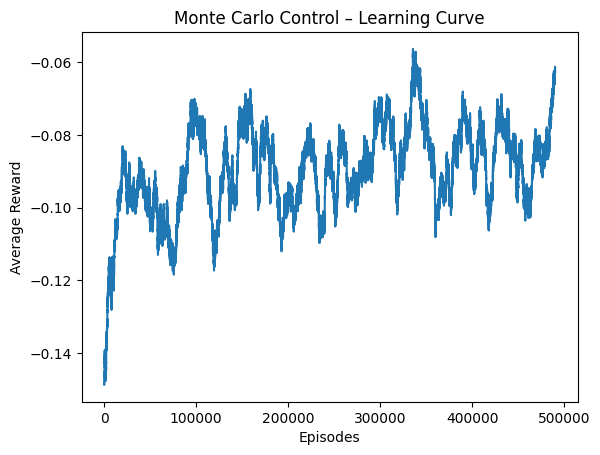

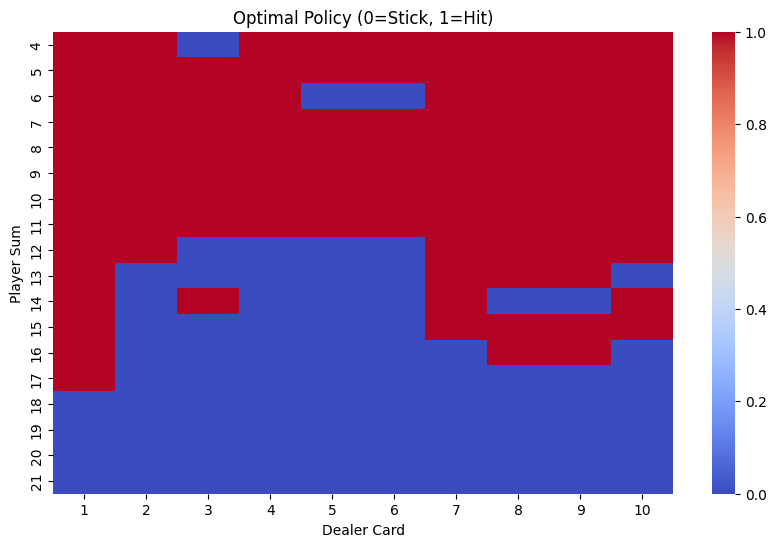

In [5]:
def rolling_average(data, window=10_000):
    return np.convolve(data, np.ones(window)/window, mode="valid")

plt.plot(rolling_average(rewards))
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Monte Carlo Control – Learning Curve")
plt.show()
policy = {}
for state in Q:
    policy[state] = np.argmax(Q[state])
heatmap = np.zeros((22, 11))

for player_sum in range(4, 22):
    for dealer_card in range(1, 11):
        heatmap[player_sum, dealer_card] = policy.get(
            (player_sum, dealer_card, False), 0
        )

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap[4:22, 1:11], cmap="coolwarm",
            xticklabels=range(1,11),
            yticklabels=range(4,22))
plt.xlabel("Dealer Card")
plt.ylabel("Player Sum")
plt.title("Optimal Policy (0=Stick, 1=Hit)")
plt.show()


**The Infinite Deck Assumption**

If the deck isn't reshuffled, the probability of drawing a card changes based on what has already been dealt. A state defined only by (PlayerSum, DealerCard) loses the "memory" of previous rounds. This violates the Markov Property, as the future no longer depends only on the present state, but on the history of the deck.

To enable card counting, the state must include a Running Count or the current composition of the deck. $S = (PlayerSum, DealerCard, UsableAce, CurrentCount)$.

Expanding the state space causes the Curse of Dimensionality. Convergence speed will slow down significantly because the agent must visit each "count" state thousands of times to learn accurate $Q$-values.

**First-Visit vs. Every-Visit**

Scenario: $A \to B \to A \to \text{Term (Reward +10)}$.Intermediate rewards: $(A \to B) = +1$, $(B \to A) = -1$.
First-Visit MC: It only looks at the first time $A$ was visited.$G = 1 (\text{step 1}) - 1 (\text{step 2}) + 10 (\text{step 3}) = 10$.
Every-Visit MC: It counts $A$ twice.

Visit 1: $G_1 = 1 - 1 + 10 = 10$

Visit 2: $G_2 = 10$

Result: The average return for $A$ would be $(10 + 10) / 2 = 10$. (In this specific case they match, but in non-terminal reward scenarios, they often differ). 